## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
#!mkdir /data
#!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
#!unzip -n /data/train-test-data.zip -d /data

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [32]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session


# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
net = net.cuda()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 68, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=35972, out_features=1088, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=1088, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [34]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(246),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [35]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 246, 246]) torch.Size([68, 2])
1 torch.Size([1, 246, 246]) torch.Size([68, 2])
2 torch.Size([1, 246, 246]) torch.Size([68, 2])
3 torch.Size([1, 246, 246]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [36]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [37]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [38]:
# load test data in batches
batch_size = 4

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [39]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        #images = images.type(torch.FloatTensor)
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, 2)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [40]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([4, 1, 246, 246])
torch.Size([4, 68, 2])
torch.Size([4, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [41]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

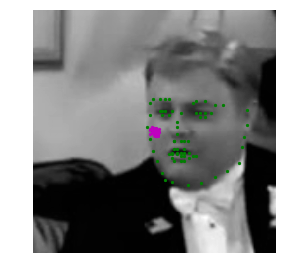

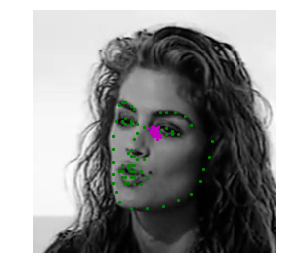

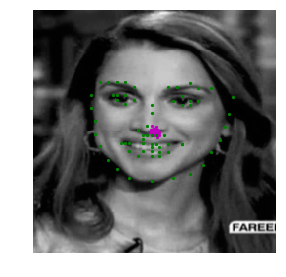

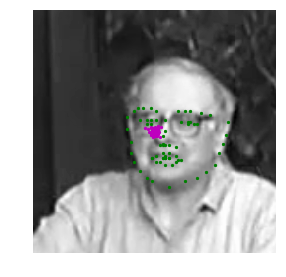

In [48]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        #image = image.numpy()   # convert to numpy array from a Tensor
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        
        #print(int(image.shape[0]/2))

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        #predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = (predicted_key_pts*((image.shape[0])/4))+((image.shape[0])/2)
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = (ground_truth_pts*((image.shape[0])/4))+((image.shape[0])/2)
            #print(ground_truth_pts)
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts,batch_size)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [43]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.95, nesterov=True)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [44]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    loss_vector = np.array([])
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            
            
            if batch_i % 50 == 49:    # print every 50 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/50))
                loss_vector = np.append(loss_vector,running_loss/50)
                running_loss = 0.0

    print('Finished Training')
    return loss_vector


In [15]:
# train your network
n_epochs = 250 # start small, and increase when you've decided on your model structure and hyperparams


# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
total_loss_3layer = train_net(n_epochs)
    

Epoch: 1, Batch: 50, Avg. Loss: 0.1606529200077057
Epoch: 1, Batch: 100, Avg. Loss: 0.09174411989748478
Epoch: 1, Batch: 150, Avg. Loss: 0.1023070827126503
Epoch: 1, Batch: 200, Avg. Loss: 0.09154648140072823
Epoch: 1, Batch: 250, Avg. Loss: 0.09428534686565399
Epoch: 1, Batch: 300, Avg. Loss: 0.08785481981933117
Epoch: 2, Batch: 50, Avg. Loss: 0.09479001693427563
Epoch: 2, Batch: 100, Avg. Loss: 0.09281621307134628
Epoch: 2, Batch: 150, Avg. Loss: 0.08691374123096467
Epoch: 2, Batch: 200, Avg. Loss: 0.09068731173872947
Epoch: 2, Batch: 250, Avg. Loss: 0.08519870832562447
Epoch: 2, Batch: 300, Avg. Loss: 0.08280149959027767
Epoch: 3, Batch: 50, Avg. Loss: 0.09616311557590962
Epoch: 3, Batch: 100, Avg. Loss: 0.0868609706312418
Epoch: 3, Batch: 150, Avg. Loss: 0.07623061873018741
Epoch: 3, Batch: 200, Avg. Loss: 0.06991304546594619
Epoch: 3, Batch: 250, Avg. Loss: 0.07916218563914298
Epoch: 3, Batch: 300, Avg. Loss: 0.08740483775734902
Epoch: 4, Batch: 50, Avg. Loss: 0.06667374059557915


Epoch: 26, Batch: 200, Avg. Loss: 0.019173552840948106
Epoch: 26, Batch: 250, Avg. Loss: 0.02083272789604962
Epoch: 26, Batch: 300, Avg. Loss: 0.014747098935768008
Epoch: 27, Batch: 50, Avg. Loss: 0.019833674104884267
Epoch: 27, Batch: 100, Avg. Loss: 0.01520150400698185
Epoch: 27, Batch: 150, Avg. Loss: 0.014549206430092453
Epoch: 27, Batch: 200, Avg. Loss: 0.015419068150222301
Epoch: 27, Batch: 250, Avg. Loss: 0.01646881125867367
Epoch: 27, Batch: 300, Avg. Loss: 0.015086806258186697
Epoch: 28, Batch: 50, Avg. Loss: 0.034189109755679965
Epoch: 28, Batch: 100, Avg. Loss: 0.013991829575970768
Epoch: 28, Batch: 150, Avg. Loss: 0.01851235513575375
Epoch: 28, Batch: 200, Avg. Loss: 0.014992353403940797
Epoch: 28, Batch: 250, Avg. Loss: 0.032380308900028465
Epoch: 28, Batch: 300, Avg. Loss: 0.014172413889318704
Epoch: 29, Batch: 50, Avg. Loss: 0.012524618646129965
Epoch: 29, Batch: 100, Avg. Loss: 0.01583665153943002
Epoch: 29, Batch: 150, Avg. Loss: 0.017084991037845613
Epoch: 29, Batch: 

Epoch: 51, Batch: 200, Avg. Loss: 0.011599417813122272
Epoch: 51, Batch: 250, Avg. Loss: 0.009261095076799392
Epoch: 51, Batch: 300, Avg. Loss: 0.008949859524145723
Epoch: 52, Batch: 50, Avg. Loss: 0.010521046100184322
Epoch: 52, Batch: 100, Avg. Loss: 0.021453526252880693
Epoch: 52, Batch: 150, Avg. Loss: 0.010189672689884901
Epoch: 52, Batch: 200, Avg. Loss: 0.008473346279934048
Epoch: 52, Batch: 250, Avg. Loss: 0.01145083031617105
Epoch: 52, Batch: 300, Avg. Loss: 0.00902906084433198
Epoch: 53, Batch: 50, Avg. Loss: 0.008067988897673786
Epoch: 53, Batch: 100, Avg. Loss: 0.009769437359645963
Epoch: 53, Batch: 150, Avg. Loss: 0.030556653747335075
Epoch: 53, Batch: 200, Avg. Loss: 0.01393173834308982
Epoch: 53, Batch: 250, Avg. Loss: 0.012621546117588877
Epoch: 53, Batch: 300, Avg. Loss: 0.008131828107871115
Epoch: 54, Batch: 50, Avg. Loss: 0.009175135903060436
Epoch: 54, Batch: 100, Avg. Loss: 0.023196135703474282
Epoch: 54, Batch: 150, Avg. Loss: 0.014759370684623718
Epoch: 54, Batch

Epoch: 76, Batch: 200, Avg. Loss: 0.007147057373076677
Epoch: 76, Batch: 250, Avg. Loss: 0.0065285346983000635
Epoch: 76, Batch: 300, Avg. Loss: 0.00972741554491222
Epoch: 77, Batch: 50, Avg. Loss: 0.007390999333001674
Epoch: 77, Batch: 100, Avg. Loss: 0.007668543145991862
Epoch: 77, Batch: 150, Avg. Loss: 0.007771357502788305
Epoch: 77, Batch: 200, Avg. Loss: 0.009405208290554584
Epoch: 77, Batch: 250, Avg. Loss: 0.007810927275568247
Epoch: 77, Batch: 300, Avg. Loss: 0.006400875370018184
Epoch: 78, Batch: 50, Avg. Loss: 0.009671125542372466
Epoch: 78, Batch: 100, Avg. Loss: 0.006951933279633522
Epoch: 78, Batch: 150, Avg. Loss: 0.0070042912987992164
Epoch: 78, Batch: 200, Avg. Loss: 0.006327203367836773
Epoch: 78, Batch: 250, Avg. Loss: 0.010085079222917556
Epoch: 78, Batch: 300, Avg. Loss: 0.007863025548867881
Epoch: 79, Batch: 50, Avg. Loss: 0.005834609786979854
Epoch: 79, Batch: 100, Avg. Loss: 0.006515269787050784
Epoch: 79, Batch: 150, Avg. Loss: 0.008417953066527843
Epoch: 79, B

Epoch: 101, Batch: 200, Avg. Loss: 0.007615212979726493
Epoch: 101, Batch: 250, Avg. Loss: 0.006624474050477147
Epoch: 101, Batch: 300, Avg. Loss: 0.005687943887896836
Epoch: 102, Batch: 50, Avg. Loss: 0.005227334601804614
Epoch: 102, Batch: 100, Avg. Loss: 0.01119870408438146
Epoch: 102, Batch: 150, Avg. Loss: 0.006912709441967309
Epoch: 102, Batch: 200, Avg. Loss: 0.006779556567780673
Epoch: 102, Batch: 250, Avg. Loss: 0.0064872298715636136
Epoch: 102, Batch: 300, Avg. Loss: 0.005578888528980315
Epoch: 103, Batch: 50, Avg. Loss: 0.013825941425748169
Epoch: 103, Batch: 100, Avg. Loss: 0.006220527226105332
Epoch: 103, Batch: 150, Avg. Loss: 0.0052444501826539635
Epoch: 103, Batch: 200, Avg. Loss: 0.008516394235193729
Epoch: 103, Batch: 250, Avg. Loss: 0.007321270224638283
Epoch: 103, Batch: 300, Avg. Loss: 0.0099144267430529
Epoch: 104, Batch: 50, Avg. Loss: 0.005821572910062969
Epoch: 104, Batch: 100, Avg. Loss: 0.006953848949633539
Epoch: 104, Batch: 150, Avg. Loss: 0.005431024702265

Epoch: 126, Batch: 50, Avg. Loss: 0.005909611256793141
Epoch: 126, Batch: 100, Avg. Loss: 0.005120080490596593
Epoch: 126, Batch: 150, Avg. Loss: 0.004490228998474777
Epoch: 126, Batch: 200, Avg. Loss: 0.005160162220709026
Epoch: 126, Batch: 250, Avg. Loss: 0.00573555298615247
Epoch: 126, Batch: 300, Avg. Loss: 0.005026101428084076
Epoch: 127, Batch: 50, Avg. Loss: 0.005032412561122328
Epoch: 127, Batch: 100, Avg. Loss: 0.008039762205444277
Epoch: 127, Batch: 150, Avg. Loss: 0.007782768299803138
Epoch: 127, Batch: 200, Avg. Loss: 0.0058281147805973885
Epoch: 127, Batch: 250, Avg. Loss: 0.005111213745549321
Epoch: 127, Batch: 300, Avg. Loss: 0.004849511389620602
Epoch: 128, Batch: 50, Avg. Loss: 0.006297590518370271
Epoch: 128, Batch: 100, Avg. Loss: 0.005735348220914602
Epoch: 128, Batch: 150, Avg. Loss: 0.004904077551327646
Epoch: 128, Batch: 200, Avg. Loss: 0.004764932948164642
Epoch: 128, Batch: 250, Avg. Loss: 0.0047671212488785385
Epoch: 128, Batch: 300, Avg. Loss: 0.0046720094559

Epoch: 150, Batch: 200, Avg. Loss: 0.005231052152812481
Epoch: 150, Batch: 250, Avg. Loss: 0.004940241598524154
Epoch: 150, Batch: 300, Avg. Loss: 0.006174040273763239
Epoch: 151, Batch: 50, Avg. Loss: 0.006471032411791384
Epoch: 151, Batch: 100, Avg. Loss: 0.010634235688485205
Epoch: 151, Batch: 150, Avg. Loss: 0.007593937655910849
Epoch: 151, Batch: 200, Avg. Loss: 0.00625645964872092
Epoch: 151, Batch: 250, Avg. Loss: 0.006109847188927233
Epoch: 151, Batch: 300, Avg. Loss: 0.005422933860681951
Epoch: 152, Batch: 50, Avg. Loss: 0.004323492469266057
Epoch: 152, Batch: 100, Avg. Loss: 0.006462894636206329
Epoch: 152, Batch: 150, Avg. Loss: 0.00523453091736883
Epoch: 152, Batch: 200, Avg. Loss: 0.004352937773801386
Epoch: 152, Batch: 250, Avg. Loss: 0.006030348986387253
Epoch: 152, Batch: 300, Avg. Loss: 0.008916270690970124
Epoch: 153, Batch: 50, Avg. Loss: 0.007301494642160833
Epoch: 153, Batch: 100, Avg. Loss: 0.004650309318676591
Epoch: 153, Batch: 150, Avg. Loss: 0.0044406907027587

Epoch: 175, Batch: 50, Avg. Loss: 0.0062142197974026205
Epoch: 175, Batch: 100, Avg. Loss: 0.00459416703786701
Epoch: 175, Batch: 150, Avg. Loss: 0.004816915839910507
Epoch: 175, Batch: 200, Avg. Loss: 0.005122936931438744
Epoch: 175, Batch: 250, Avg. Loss: 0.004927541520446539
Epoch: 175, Batch: 300, Avg. Loss: 0.0044198415451683105
Epoch: 176, Batch: 50, Avg. Loss: 0.008311565639451146
Epoch: 176, Batch: 100, Avg. Loss: 0.004849754436872899
Epoch: 176, Batch: 150, Avg. Loss: 0.004638046598993242
Epoch: 176, Batch: 200, Avg. Loss: 0.004418743888381868
Epoch: 176, Batch: 250, Avg. Loss: 0.004749336959794164
Epoch: 176, Batch: 300, Avg. Loss: 0.004504790636710823
Epoch: 177, Batch: 50, Avg. Loss: 0.005220695128664374
Epoch: 177, Batch: 100, Avg. Loss: 0.004283955479040742
Epoch: 177, Batch: 150, Avg. Loss: 0.0041436332603916525
Epoch: 177, Batch: 200, Avg. Loss: 0.0038583425246179106
Epoch: 177, Batch: 250, Avg. Loss: 0.004157061967998743
Epoch: 177, Batch: 300, Avg. Loss: 0.00436095227

Epoch: 199, Batch: 200, Avg. Loss: 0.0038410821347497404
Epoch: 199, Batch: 250, Avg. Loss: 0.004111717850901186
Epoch: 199, Batch: 300, Avg. Loss: 0.003987677176482975
Epoch: 200, Batch: 50, Avg. Loss: 0.005196845508180559
Epoch: 200, Batch: 100, Avg. Loss: 0.007318697581067682
Epoch: 200, Batch: 150, Avg. Loss: 0.004707106875721365
Epoch: 200, Batch: 200, Avg. Loss: 0.003801564867608249
Epoch: 200, Batch: 250, Avg. Loss: 0.004369698758237064
Epoch: 200, Batch: 300, Avg. Loss: 0.005070811016485095
Epoch: 201, Batch: 50, Avg. Loss: 0.011401848387904465
Epoch: 201, Batch: 100, Avg. Loss: 0.005552453566342592
Epoch: 201, Batch: 150, Avg. Loss: 0.004215027960017323
Epoch: 201, Batch: 200, Avg. Loss: 0.0039108612947165965
Epoch: 201, Batch: 250, Avg. Loss: 0.004033087820280343
Epoch: 201, Batch: 300, Avg. Loss: 0.0041926583787426355
Epoch: 202, Batch: 50, Avg. Loss: 0.004408347099088133
Epoch: 202, Batch: 100, Avg. Loss: 0.004091132287867367
Epoch: 202, Batch: 150, Avg. Loss: 0.00392593663

Epoch: 224, Batch: 50, Avg. Loss: 0.003972581753041595
Epoch: 224, Batch: 100, Avg. Loss: 0.00406236378941685
Epoch: 224, Batch: 150, Avg. Loss: 0.003890811107121408
Epoch: 224, Batch: 200, Avg. Loss: 0.0038220983999781312
Epoch: 224, Batch: 250, Avg. Loss: 0.003994124967139214
Epoch: 224, Batch: 300, Avg. Loss: 0.003909462941810489
Epoch: 225, Batch: 50, Avg. Loss: 0.0033470783336088062
Epoch: 225, Batch: 100, Avg. Loss: 0.003893965380266309
Epoch: 225, Batch: 150, Avg. Loss: 0.00383477745577693
Epoch: 225, Batch: 200, Avg. Loss: 0.003945108675397932
Epoch: 225, Batch: 250, Avg. Loss: 0.003634413513354957
Epoch: 225, Batch: 300, Avg. Loss: 0.003915989897213876
Epoch: 226, Batch: 50, Avg. Loss: 0.0036179788247682155
Epoch: 226, Batch: 100, Avg. Loss: 0.003612424354068935
Epoch: 226, Batch: 150, Avg. Loss: 0.004389386475086212
Epoch: 226, Batch: 200, Avg. Loss: 0.0040293939621187744
Epoch: 226, Batch: 250, Avg. Loss: 0.004638559692539275
Epoch: 226, Batch: 300, Avg. Loss: 0.003882534587

Epoch: 248, Batch: 200, Avg. Loss: 0.0038846267410553993
Epoch: 248, Batch: 250, Avg. Loss: 0.003756624567322433
Epoch: 248, Batch: 300, Avg. Loss: 0.003220458966679871
Epoch: 249, Batch: 50, Avg. Loss: 0.004155572620220482
Epoch: 249, Batch: 100, Avg. Loss: 0.0050097110541537405
Epoch: 249, Batch: 150, Avg. Loss: 0.0038194032851606606
Epoch: 249, Batch: 200, Avg. Loss: 0.0035619227564893663
Epoch: 249, Batch: 250, Avg. Loss: 0.0035487240995280443
Epoch: 249, Batch: 300, Avg. Loss: 0.003497051578015089
Epoch: 250, Batch: 50, Avg. Loss: 0.0038781137438490985
Epoch: 250, Batch: 100, Avg. Loss: 0.003492063446901739
Epoch: 250, Batch: 150, Avg. Loss: 0.0034678228641860185
Epoch: 250, Batch: 200, Avg. Loss: 0.003308469862677157
Epoch: 250, Batch: 250, Avg. Loss: 0.0033239827677607535
Epoch: 250, Batch: 300, Avg. Loss: 0.004274859067518264
Finished Training


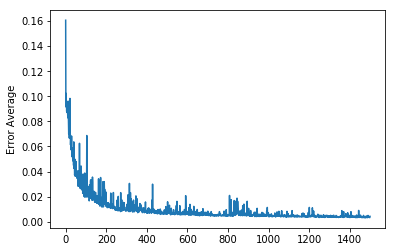

In [16]:
import matplotlib.pyplot as plt

plt.plot(total_loss_3layer)
plt.ylabel('Error Average')
plt.show()



## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [50]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([4, 1, 246, 246])
torch.Size([4, 68, 2])
torch.Size([4, 68, 2])


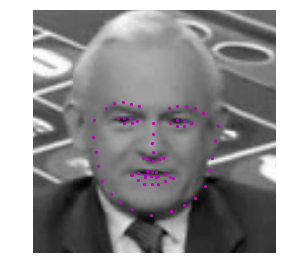

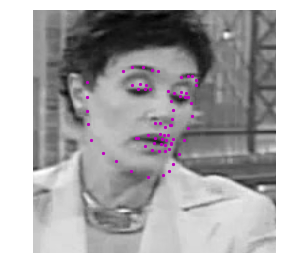

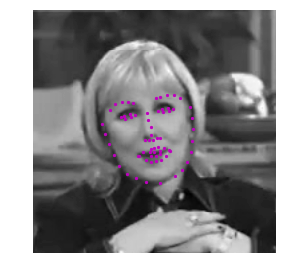

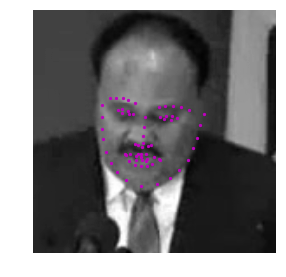

In [51]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs,batch_size=batch_size)

In [45]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_3layer_arch_MSELoss.pt'

# after training, save your model parameters in the dir 'saved_models'
#torch.save(net.state_dict(), model_dir+model_name)

In [49]:
#Loads model
net = Net()
net.load_state_dict(torch.load(model_dir+model_name))
net = net.cuda()
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 68, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=35972, out_features=1088, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=1088, out_features=136, bias=True)
)

Now, I will change to another model found in the references, using 5 layers instead of 2.

In [21]:
from models_5layers import Net

net = Net()
net = net.cuda()
print(net)

Net(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(192, 288, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=28800, out_features=1088, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2): Linear(in_features=1088, out_features=136, bias=True)
)


In [22]:
criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.9, nesterov=True)
#optimizer = optim.Adam(net.parameters(),lr=0.01,weight_decay=1e-4)

# train your network
n_epochs = 250 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
total_loss_5layer = train_net(n_epochs)
    


Epoch: 1, Batch: 50, Avg. Loss: 0.20829504281282424
Epoch: 1, Batch: 100, Avg. Loss: 0.10910856053233146
Epoch: 1, Batch: 150, Avg. Loss: 0.10821972854435444
Epoch: 1, Batch: 200, Avg. Loss: 0.09400467596948146
Epoch: 1, Batch: 250, Avg. Loss: 0.10892726682126522
Epoch: 1, Batch: 300, Avg. Loss: 0.09330760948359966
Epoch: 2, Batch: 50, Avg. Loss: 0.0881706104427576
Epoch: 2, Batch: 100, Avg. Loss: 0.09625585541129113
Epoch: 2, Batch: 150, Avg. Loss: 0.10439491353929042
Epoch: 2, Batch: 200, Avg. Loss: 0.08748822167515755
Epoch: 2, Batch: 250, Avg. Loss: 0.11650269880890846
Epoch: 2, Batch: 300, Avg. Loss: 0.08634487375617027
Epoch: 3, Batch: 50, Avg. Loss: 0.08995613910257816
Epoch: 3, Batch: 100, Avg. Loss: 0.10030267126858235
Epoch: 3, Batch: 150, Avg. Loss: 0.08955572187900543
Epoch: 3, Batch: 200, Avg. Loss: 0.08843676291406155
Epoch: 3, Batch: 250, Avg. Loss: 0.09613042831420898
Epoch: 3, Batch: 300, Avg. Loss: 0.0907951483130455
Epoch: 4, Batch: 50, Avg. Loss: 0.09354994736611844

Epoch: 26, Batch: 200, Avg. Loss: 0.024551651515066622
Epoch: 26, Batch: 250, Avg. Loss: 0.023928259667009115
Epoch: 26, Batch: 300, Avg. Loss: 0.028498953683301808
Epoch: 27, Batch: 50, Avg. Loss: 0.02544262686744332
Epoch: 27, Batch: 100, Avg. Loss: 0.018839132618159057
Epoch: 27, Batch: 150, Avg. Loss: 0.01603931674733758
Epoch: 27, Batch: 200, Avg. Loss: 0.017095517702400684
Epoch: 27, Batch: 250, Avg. Loss: 0.017819037903100254
Epoch: 27, Batch: 300, Avg. Loss: 0.018769281012937428
Epoch: 28, Batch: 50, Avg. Loss: 0.016495245527476072
Epoch: 28, Batch: 100, Avg. Loss: 0.015219644960016012
Epoch: 28, Batch: 150, Avg. Loss: 0.014663923922926187
Epoch: 28, Batch: 200, Avg. Loss: 0.01694633242674172
Epoch: 28, Batch: 250, Avg. Loss: 0.018821255341172217
Epoch: 28, Batch: 300, Avg. Loss: 0.03718136014416814
Epoch: 29, Batch: 50, Avg. Loss: 0.025258924020454286
Epoch: 29, Batch: 100, Avg. Loss: 0.022960563777014612
Epoch: 29, Batch: 150, Avg. Loss: 0.018740392420440913
Epoch: 29, Batch:

Epoch: 51, Batch: 250, Avg. Loss: 0.008959701154381036
Epoch: 51, Batch: 300, Avg. Loss: 0.008060054965317249
Epoch: 52, Batch: 50, Avg. Loss: 0.01063730225432664
Epoch: 52, Batch: 100, Avg. Loss: 0.01013019921258092
Epoch: 52, Batch: 150, Avg. Loss: 0.008269707281142473
Epoch: 52, Batch: 200, Avg. Loss: 0.02473959212191403
Epoch: 52, Batch: 250, Avg. Loss: 0.010164612419903279
Epoch: 52, Batch: 300, Avg. Loss: 0.014633404230698943
Epoch: 53, Batch: 50, Avg. Loss: 0.009276995034888387
Epoch: 53, Batch: 100, Avg. Loss: 0.01200708775781095
Epoch: 53, Batch: 150, Avg. Loss: 0.019426887724548578
Epoch: 53, Batch: 200, Avg. Loss: 0.010369814857840538
Epoch: 53, Batch: 250, Avg. Loss: 0.008565471582114697
Epoch: 53, Batch: 300, Avg. Loss: 0.010074883494526147
Epoch: 54, Batch: 50, Avg. Loss: 0.010085550909861922
Epoch: 54, Batch: 100, Avg. Loss: 0.009117760919034481
Epoch: 54, Batch: 150, Avg. Loss: 0.015227054683491588
Epoch: 54, Batch: 200, Avg. Loss: 0.008350745821371675
Epoch: 54, Batch:

Epoch: 76, Batch: 250, Avg. Loss: 0.009310259958729148
Epoch: 76, Batch: 300, Avg. Loss: 0.006579833393916487
Epoch: 77, Batch: 50, Avg. Loss: 0.006344183227047324
Epoch: 77, Batch: 100, Avg. Loss: 0.006289316946640611
Epoch: 77, Batch: 150, Avg. Loss: 0.006245585707947612
Epoch: 77, Batch: 200, Avg. Loss: 0.00666895279660821
Epoch: 77, Batch: 250, Avg. Loss: 0.007846425264142453
Epoch: 77, Batch: 300, Avg. Loss: 0.010696437326259911
Epoch: 78, Batch: 50, Avg. Loss: 0.006274433247745037
Epoch: 78, Batch: 100, Avg. Loss: 0.007413040893152356
Epoch: 78, Batch: 150, Avg. Loss: 0.006580150546506047
Epoch: 78, Batch: 200, Avg. Loss: 0.0067603857629001144
Epoch: 78, Batch: 250, Avg. Loss: 0.008925682180561126
Epoch: 78, Batch: 300, Avg. Loss: 0.014701586617156863
Epoch: 79, Batch: 50, Avg. Loss: 0.007188719194382429
Epoch: 79, Batch: 100, Avg. Loss: 0.006819401886314153
Epoch: 79, Batch: 150, Avg. Loss: 0.006875921031460166
Epoch: 79, Batch: 200, Avg. Loss: 0.007004851251840591
Epoch: 79, Ba

Epoch: 101, Batch: 250, Avg. Loss: 0.005989810572937131
Epoch: 101, Batch: 300, Avg. Loss: 0.005665680123493075
Epoch: 102, Batch: 50, Avg. Loss: 0.004994194814935326
Epoch: 102, Batch: 100, Avg. Loss: 0.005172108206897974
Epoch: 102, Batch: 150, Avg. Loss: 0.0055022327741608024
Epoch: 102, Batch: 200, Avg. Loss: 0.006192415715195239
Epoch: 102, Batch: 250, Avg. Loss: 0.005178892984986305
Epoch: 102, Batch: 300, Avg. Loss: 0.006275173272006214
Epoch: 103, Batch: 50, Avg. Loss: 0.0059748578257858755
Epoch: 103, Batch: 100, Avg. Loss: 0.005508233411237597
Epoch: 103, Batch: 150, Avg. Loss: 0.005589328096248209
Epoch: 103, Batch: 200, Avg. Loss: 0.005483545954339206
Epoch: 103, Batch: 250, Avg. Loss: 0.005242119734175503
Epoch: 103, Batch: 300, Avg. Loss: 0.009434115388430656
Epoch: 104, Batch: 50, Avg. Loss: 0.0051301826676353815
Epoch: 104, Batch: 100, Avg. Loss: 0.005999205210246146
Epoch: 104, Batch: 150, Avg. Loss: 0.006214190381579101
Epoch: 104, Batch: 200, Avg. Loss: 0.00607096598

Epoch: 126, Batch: 100, Avg. Loss: 0.004832881600596011
Epoch: 126, Batch: 150, Avg. Loss: 0.004647677270695567
Epoch: 126, Batch: 200, Avg. Loss: 0.005221406389027834
Epoch: 126, Batch: 250, Avg. Loss: 0.007933032908476889
Epoch: 126, Batch: 300, Avg. Loss: 0.00496324100997299
Epoch: 127, Batch: 50, Avg. Loss: 0.005583209055475891
Epoch: 127, Batch: 100, Avg. Loss: 0.004714938425458968
Epoch: 127, Batch: 150, Avg. Loss: 0.004566920925863087
Epoch: 127, Batch: 200, Avg. Loss: 0.004511332768015563
Epoch: 127, Batch: 250, Avg. Loss: 0.0044059806689620016
Epoch: 127, Batch: 300, Avg. Loss: 0.00600862501654774
Epoch: 128, Batch: 50, Avg. Loss: 0.0046256371075287465
Epoch: 128, Batch: 100, Avg. Loss: 0.004565149289555847
Epoch: 128, Batch: 150, Avg. Loss: 0.004810780705884099
Epoch: 128, Batch: 200, Avg. Loss: 0.004592364877462387
Epoch: 128, Batch: 250, Avg. Loss: 0.004611139511689543
Epoch: 128, Batch: 300, Avg. Loss: 0.004135883278213442
Epoch: 129, Batch: 50, Avg. Loss: 0.00485346398316

Epoch: 150, Batch: 250, Avg. Loss: 0.005292819649912417
Epoch: 150, Batch: 300, Avg. Loss: 0.004389969310723245
Epoch: 151, Batch: 50, Avg. Loss: 0.0043309082882478835
Epoch: 151, Batch: 100, Avg. Loss: 0.004261186593212187
Epoch: 151, Batch: 150, Avg. Loss: 0.0043669264158234
Epoch: 151, Batch: 200, Avg. Loss: 0.0037128417752683163
Epoch: 151, Batch: 250, Avg. Loss: 0.0038410853128880264
Epoch: 151, Batch: 300, Avg. Loss: 0.0038676254823803904
Epoch: 152, Batch: 50, Avg. Loss: 0.0043018457666039464
Epoch: 152, Batch: 100, Avg. Loss: 0.0040663608815521
Epoch: 152, Batch: 150, Avg. Loss: 0.0044568982860073445
Epoch: 152, Batch: 200, Avg. Loss: 0.0038678983971476553
Epoch: 152, Batch: 250, Avg. Loss: 0.0042290024692192675
Epoch: 152, Batch: 300, Avg. Loss: 0.005635248450562358
Epoch: 153, Batch: 50, Avg. Loss: 0.00437905203551054
Epoch: 153, Batch: 100, Avg. Loss: 0.004521831660531462
Epoch: 153, Batch: 150, Avg. Loss: 0.003962645479477942
Epoch: 153, Batch: 200, Avg. Loss: 0.00436462231

Epoch: 175, Batch: 100, Avg. Loss: 0.004035297208465636
Epoch: 175, Batch: 150, Avg. Loss: 0.004143527508713305
Epoch: 175, Batch: 200, Avg. Loss: 0.0036974727874621747
Epoch: 175, Batch: 250, Avg. Loss: 0.003919269279576838
Epoch: 175, Batch: 300, Avg. Loss: 0.0037053786404430866
Epoch: 176, Batch: 50, Avg. Loss: 0.004089148691855371
Epoch: 176, Batch: 100, Avg. Loss: 0.004383436804637313
Epoch: 176, Batch: 150, Avg. Loss: 0.0040411842591129244
Epoch: 176, Batch: 200, Avg. Loss: 0.003582684420980513
Epoch: 176, Batch: 250, Avg. Loss: 0.0037039609346538782
Epoch: 176, Batch: 300, Avg. Loss: 0.0039947691513225435
Epoch: 177, Batch: 50, Avg. Loss: 0.003767469176091254
Epoch: 177, Batch: 100, Avg. Loss: 0.0049260866222903136
Epoch: 177, Batch: 150, Avg. Loss: 0.004120000782422722
Epoch: 177, Batch: 200, Avg. Loss: 0.00405441498849541
Epoch: 177, Batch: 250, Avg. Loss: 0.003528684563934803
Epoch: 177, Batch: 300, Avg. Loss: 0.003596096890978515
Epoch: 178, Batch: 50, Avg. Loss: 0.003815969

Epoch: 199, Batch: 200, Avg. Loss: 0.0031561713200062512
Epoch: 199, Batch: 250, Avg. Loss: 0.003733731093816459
Epoch: 199, Batch: 300, Avg. Loss: 0.003821503960061818
Epoch: 200, Batch: 50, Avg. Loss: 0.003544602314941585
Epoch: 200, Batch: 100, Avg. Loss: 0.003572505656629801
Epoch: 200, Batch: 150, Avg. Loss: 0.0038489340548403563
Epoch: 200, Batch: 200, Avg. Loss: 0.003959666816517711
Epoch: 200, Batch: 250, Avg. Loss: 0.0039072655467316504
Epoch: 200, Batch: 300, Avg. Loss: 0.004090959038585425
Epoch: 201, Batch: 50, Avg. Loss: 0.0033972009597346186
Epoch: 201, Batch: 100, Avg. Loss: 0.003568619070574641
Epoch: 201, Batch: 150, Avg. Loss: 0.003640060513280332
Epoch: 201, Batch: 200, Avg. Loss: 0.0038201123452745378
Epoch: 201, Batch: 250, Avg. Loss: 0.003319446409586817
Epoch: 201, Batch: 300, Avg. Loss: 0.0033082344569265844
Epoch: 202, Batch: 50, Avg. Loss: 0.0035454955673776566
Epoch: 202, Batch: 100, Avg. Loss: 0.005239013428799808
Epoch: 202, Batch: 150, Avg. Loss: 0.0039721

Epoch: 223, Batch: 300, Avg. Loss: 0.0034316472662612794
Epoch: 224, Batch: 50, Avg. Loss: 0.003419055270496756
Epoch: 224, Batch: 100, Avg. Loss: 0.0031836574338376523
Epoch: 224, Batch: 150, Avg. Loss: 0.0032111903792247177
Epoch: 224, Batch: 200, Avg. Loss: 0.0037674423842690885
Epoch: 224, Batch: 250, Avg. Loss: 0.0035699345194734632
Epoch: 224, Batch: 300, Avg. Loss: 0.0033759764209389687
Epoch: 225, Batch: 50, Avg. Loss: 0.003474892273079604
Epoch: 225, Batch: 100, Avg. Loss: 0.0034264009445905685
Epoch: 225, Batch: 150, Avg. Loss: 0.0032014853111468258
Epoch: 225, Batch: 200, Avg. Loss: 0.003186702341772616
Epoch: 225, Batch: 250, Avg. Loss: 0.0037859656615182756
Epoch: 225, Batch: 300, Avg. Loss: 0.0037853816198185086
Epoch: 226, Batch: 50, Avg. Loss: 0.003518981821835041
Epoch: 226, Batch: 100, Avg. Loss: 0.0033166407723911107
Epoch: 226, Batch: 150, Avg. Loss: 0.0035080235823988916
Epoch: 226, Batch: 200, Avg. Loss: 0.0034732673317193984
Epoch: 226, Batch: 250, Avg. Loss: 0.0

Epoch: 248, Batch: 100, Avg. Loss: 0.004439403619617224
Epoch: 248, Batch: 150, Avg. Loss: 0.003341602154541761
Epoch: 248, Batch: 200, Avg. Loss: 0.003225709977559745
Epoch: 248, Batch: 250, Avg. Loss: 0.002894525632727891
Epoch: 248, Batch: 300, Avg. Loss: 0.0032552455691620707
Epoch: 249, Batch: 50, Avg. Loss: 0.003334237874951214
Epoch: 249, Batch: 100, Avg. Loss: 0.0031196352164261044
Epoch: 249, Batch: 150, Avg. Loss: 0.003261968947481364
Epoch: 249, Batch: 200, Avg. Loss: 0.0030670468602329495
Epoch: 249, Batch: 250, Avg. Loss: 0.0035190123692154882
Epoch: 249, Batch: 300, Avg. Loss: 0.0029055863944813607
Epoch: 250, Batch: 50, Avg. Loss: 0.00310979692498222
Epoch: 250, Batch: 100, Avg. Loss: 0.00341230689547956
Epoch: 250, Batch: 150, Avg. Loss: 0.003169414650183171
Epoch: 250, Batch: 200, Avg. Loss: 0.003712672560941428
Epoch: 250, Batch: 250, Avg. Loss: 0.003973752069287002
Epoch: 250, Batch: 300, Avg. Loss: 0.003361385331954807
Finished Training


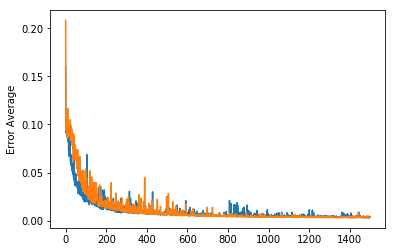

In [23]:
#show progression graph
plt.plot(total_loss_3layer,label='3 Layer CNN')
plt.plot(total_loss_5layer,label='5 Layer CNN')
plt.ylabel('Error Average')
plt.show()

In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs,batch_size = batch_size)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [25]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_5layer_arch_MSELoss.pt'

# after training, save your model parameters in the dir 'saved_models'
#torch.save(net.state_dict(), model_dir+model_name)

In [26]:
#Loads model
#net = Net()
#net.load_state_dict(torch.load(model_dir+model_name))
#net.eval()

Now, testing the NamishNet.

In [27]:
from namishnet import Net

net = Net()
net = net.cuda()

criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.95, nesterov=True)
#optimizer = optim.Adam(net.parameters(),lr=0.01,weight_decay=1e-4)

# train your network
n_epochs = 250 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
total_loss_namish = train_net(n_epochs)

Epoch: 1, Batch: 50, Avg. Loss: 0.2118662901222706
Epoch: 1, Batch: 100, Avg. Loss: 0.1079859808087349
Epoch: 1, Batch: 150, Avg. Loss: 0.09922977469861508
Epoch: 1, Batch: 200, Avg. Loss: 0.1065193124115467
Epoch: 1, Batch: 250, Avg. Loss: 0.0988332100212574
Epoch: 1, Batch: 300, Avg. Loss: 0.09512576177716255
Epoch: 2, Batch: 50, Avg. Loss: 0.10649711713194847
Epoch: 2, Batch: 100, Avg. Loss: 0.09186938367784023
Epoch: 2, Batch: 150, Avg. Loss: 0.08886441968381405
Epoch: 2, Batch: 200, Avg. Loss: 0.09245056129992008
Epoch: 2, Batch: 250, Avg. Loss: 0.09252696461975575
Epoch: 2, Batch: 300, Avg. Loss: 0.08735069662332534
Epoch: 3, Batch: 50, Avg. Loss: 0.0921132878214121
Epoch: 3, Batch: 100, Avg. Loss: 0.09711916334927082
Epoch: 3, Batch: 150, Avg. Loss: 0.09855492003262042
Epoch: 3, Batch: 200, Avg. Loss: 0.105701844394207
Epoch: 3, Batch: 250, Avg. Loss: 0.08649703718721867
Epoch: 3, Batch: 300, Avg. Loss: 0.09780871167778969
Epoch: 4, Batch: 50, Avg. Loss: 0.09693668648600579
Epoc

Epoch: 26, Batch: 250, Avg. Loss: 0.07843202844262123
Epoch: 26, Batch: 300, Avg. Loss: 0.06814395505934953
Epoch: 27, Batch: 50, Avg. Loss: 0.06206794872879982
Epoch: 27, Batch: 100, Avg. Loss: 0.06781375177204609
Epoch: 27, Batch: 150, Avg. Loss: 0.05994935017079115
Epoch: 27, Batch: 200, Avg. Loss: 0.06144944556057453
Epoch: 27, Batch: 250, Avg. Loss: 0.05697590567171574
Epoch: 27, Batch: 300, Avg. Loss: 0.0595906026288867
Epoch: 28, Batch: 50, Avg. Loss: 0.057899349741637705
Epoch: 28, Batch: 100, Avg. Loss: 0.06584400825202465
Epoch: 28, Batch: 150, Avg. Loss: 0.05790828689932823
Epoch: 28, Batch: 200, Avg. Loss: 0.0564987288787961
Epoch: 28, Batch: 250, Avg. Loss: 0.09426534693688154
Epoch: 28, Batch: 300, Avg. Loss: 0.056197647377848624
Epoch: 29, Batch: 50, Avg. Loss: 0.07931480254977942
Epoch: 29, Batch: 100, Avg. Loss: 0.061537837237119676
Epoch: 29, Batch: 150, Avg. Loss: 0.05593464683741331
Epoch: 29, Batch: 200, Avg. Loss: 0.0790689730271697
Epoch: 29, Batch: 250, Avg. Los

Epoch: 52, Batch: 50, Avg. Loss: 0.04373954154551029
Epoch: 52, Batch: 100, Avg. Loss: 0.05271888215094805
Epoch: 52, Batch: 150, Avg. Loss: 0.0429327953979373
Epoch: 52, Batch: 200, Avg. Loss: 0.05406595226377249
Epoch: 52, Batch: 250, Avg. Loss: 0.06295552456751466
Epoch: 52, Batch: 300, Avg. Loss: 0.040989823043346404
Epoch: 53, Batch: 50, Avg. Loss: 0.04198515180498361
Epoch: 53, Batch: 100, Avg. Loss: 0.035942909754812714
Epoch: 53, Batch: 150, Avg. Loss: 0.06487277926877141
Epoch: 53, Batch: 200, Avg. Loss: 0.04090124942362308
Epoch: 53, Batch: 250, Avg. Loss: 0.052462129145860674
Epoch: 53, Batch: 300, Avg. Loss: 0.0387074376270175
Epoch: 54, Batch: 50, Avg. Loss: 0.042011846490204334
Epoch: 54, Batch: 100, Avg. Loss: 0.04249266929924488
Epoch: 54, Batch: 150, Avg. Loss: 0.05423109836876392
Epoch: 54, Batch: 200, Avg. Loss: 0.03967808086425066
Epoch: 54, Batch: 250, Avg. Loss: 0.04807907979935408
Epoch: 54, Batch: 300, Avg. Loss: 0.03800164174288511
Epoch: 55, Batch: 50, Avg. Lo

Epoch: 77, Batch: 150, Avg. Loss: 0.023938959296792746
Epoch: 77, Batch: 200, Avg. Loss: 0.021649426873773338
Epoch: 77, Batch: 250, Avg. Loss: 0.028101762775331735
Epoch: 77, Batch: 300, Avg. Loss: 0.02363978972658515
Epoch: 78, Batch: 50, Avg. Loss: 0.022283403016626836
Epoch: 78, Batch: 100, Avg. Loss: 0.023233078867197037
Epoch: 78, Batch: 150, Avg. Loss: 0.02485137905925512
Epoch: 78, Batch: 200, Avg. Loss: 0.022600667104125022
Epoch: 78, Batch: 250, Avg. Loss: 0.02195213107392192
Epoch: 78, Batch: 300, Avg. Loss: 0.0354912743344903
Epoch: 79, Batch: 50, Avg. Loss: 0.020882434714585542
Epoch: 79, Batch: 100, Avg. Loss: 0.02611566849052906
Epoch: 79, Batch: 150, Avg. Loss: 0.024673149771988392
Epoch: 79, Batch: 200, Avg. Loss: 0.02455146262422204
Epoch: 79, Batch: 250, Avg. Loss: 0.03534170994535089
Epoch: 79, Batch: 300, Avg. Loss: 0.02384165095165372
Epoch: 80, Batch: 50, Avg. Loss: 0.02284921959042549
Epoch: 80, Batch: 100, Avg. Loss: 0.03137626051902771
Epoch: 80, Batch: 150, A

Epoch: 103, Batch: 50, Avg. Loss: 0.015403346456587315
Epoch: 103, Batch: 100, Avg. Loss: 0.019302506549283862
Epoch: 103, Batch: 150, Avg. Loss: 0.01879146445542574
Epoch: 103, Batch: 200, Avg. Loss: 0.01831196390092373
Epoch: 103, Batch: 250, Avg. Loss: 0.020825282968580723
Epoch: 103, Batch: 300, Avg. Loss: 0.016910587809979914
Epoch: 104, Batch: 50, Avg. Loss: 0.018740152157843113
Epoch: 104, Batch: 100, Avg. Loss: 0.01729304911568761
Epoch: 104, Batch: 150, Avg. Loss: 0.026736392322927714
Epoch: 104, Batch: 200, Avg. Loss: 0.017847165111452342
Epoch: 104, Batch: 250, Avg. Loss: 0.02045300681143999
Epoch: 104, Batch: 300, Avg. Loss: 0.020816861540079116
Epoch: 105, Batch: 50, Avg. Loss: 0.021434792075306176
Epoch: 105, Batch: 100, Avg. Loss: 0.016956562250852583
Epoch: 105, Batch: 150, Avg. Loss: 0.01811607432551682
Epoch: 105, Batch: 200, Avg. Loss: 0.016660075131803752
Epoch: 105, Batch: 250, Avg. Loss: 0.022796105332672595
Epoch: 105, Batch: 300, Avg. Loss: 0.01876721628010273
E

Epoch: 127, Batch: 250, Avg. Loss: 0.015136623149737715
Epoch: 127, Batch: 300, Avg. Loss: 0.01879699564538896
Epoch: 128, Batch: 50, Avg. Loss: 0.014470870615914464
Epoch: 128, Batch: 100, Avg. Loss: 0.015490957498550416
Epoch: 128, Batch: 150, Avg. Loss: 0.015258508939296008
Epoch: 128, Batch: 200, Avg. Loss: 0.015507200211286544
Epoch: 128, Batch: 250, Avg. Loss: 0.017231564167886973
Epoch: 128, Batch: 300, Avg. Loss: 0.015841614548116924
Epoch: 129, Batch: 50, Avg. Loss: 0.014789140298962593
Epoch: 129, Batch: 100, Avg. Loss: 0.016499648299068213
Epoch: 129, Batch: 150, Avg. Loss: 0.0219571890309453
Epoch: 129, Batch: 200, Avg. Loss: 0.017566809225827457
Epoch: 129, Batch: 250, Avg. Loss: 0.014675517547875643
Epoch: 129, Batch: 300, Avg. Loss: 0.020396172683686018
Epoch: 130, Batch: 50, Avg. Loss: 0.013396776579320431
Epoch: 130, Batch: 100, Avg. Loss: 0.015093409661203623
Epoch: 130, Batch: 150, Avg. Loss: 0.015000148108229042
Epoch: 130, Batch: 200, Avg. Loss: 0.01548419717699289

Epoch: 152, Batch: 150, Avg. Loss: 0.017432424006983638
Epoch: 152, Batch: 200, Avg. Loss: 0.014596222452819347
Epoch: 152, Batch: 250, Avg. Loss: 0.011590735362842679
Epoch: 152, Batch: 300, Avg. Loss: 0.014120885860174895
Epoch: 153, Batch: 50, Avg. Loss: 0.013820094196125865
Epoch: 153, Batch: 100, Avg. Loss: 0.012852137591689825
Epoch: 153, Batch: 150, Avg. Loss: 0.013204098399728536
Epoch: 153, Batch: 200, Avg. Loss: 0.015426295707002283
Epoch: 153, Batch: 250, Avg. Loss: 0.011823998438194394
Epoch: 153, Batch: 300, Avg. Loss: 0.012615841580554843
Epoch: 154, Batch: 50, Avg. Loss: 0.012811795827001333
Epoch: 154, Batch: 100, Avg. Loss: 0.011331639597192406
Epoch: 154, Batch: 150, Avg. Loss: 0.013278447082266212
Epoch: 154, Batch: 200, Avg. Loss: 0.019960277657955886
Epoch: 154, Batch: 250, Avg. Loss: 0.016720786821097136
Epoch: 154, Batch: 300, Avg. Loss: 0.013221866162493824
Epoch: 155, Batch: 50, Avg. Loss: 0.014007776798680425
Epoch: 155, Batch: 100, Avg. Loss: 0.01280956379137

Epoch: 177, Batch: 50, Avg. Loss: 0.012821529870852827
Epoch: 177, Batch: 100, Avg. Loss: 0.012723569488152862
Epoch: 177, Batch: 150, Avg. Loss: 0.01093670103698969
Epoch: 177, Batch: 200, Avg. Loss: 0.014427657602354885
Epoch: 177, Batch: 250, Avg. Loss: 0.013795542744919658
Epoch: 177, Batch: 300, Avg. Loss: 0.011452110223472119
Epoch: 178, Batch: 50, Avg. Loss: 0.01321104441769421
Epoch: 178, Batch: 100, Avg. Loss: 0.012168971709907056
Epoch: 178, Batch: 150, Avg. Loss: 0.011609028456732631
Epoch: 178, Batch: 200, Avg. Loss: 0.010469179106876255
Epoch: 178, Batch: 250, Avg. Loss: 0.013055004272609949
Epoch: 178, Batch: 300, Avg. Loss: 0.01320159612223506
Epoch: 179, Batch: 50, Avg. Loss: 0.012035470558330416
Epoch: 179, Batch: 100, Avg. Loss: 0.011003919718787074
Epoch: 179, Batch: 150, Avg. Loss: 0.011934213256463409
Epoch: 179, Batch: 200, Avg. Loss: 0.010786787495017052
Epoch: 179, Batch: 250, Avg. Loss: 0.01290402646176517
Epoch: 179, Batch: 300, Avg. Loss: 0.011560693746432663

Epoch: 201, Batch: 250, Avg. Loss: 0.035554522825405
Epoch: 201, Batch: 300, Avg. Loss: 0.015282807052135467
Epoch: 202, Batch: 50, Avg. Loss: 0.014580082213506103
Epoch: 202, Batch: 100, Avg. Loss: 0.011470580669119955
Epoch: 202, Batch: 150, Avg. Loss: 0.012535812836140393
Epoch: 202, Batch: 200, Avg. Loss: 0.011578472200781106
Epoch: 202, Batch: 250, Avg. Loss: 0.01443712688051164
Epoch: 202, Batch: 300, Avg. Loss: 0.011310485629364849
Epoch: 203, Batch: 50, Avg. Loss: 0.012511505633592606
Epoch: 203, Batch: 100, Avg. Loss: 0.011750931702554226
Epoch: 203, Batch: 150, Avg. Loss: 0.013367130272090435
Epoch: 203, Batch: 200, Avg. Loss: 0.011238568108528852
Epoch: 203, Batch: 250, Avg. Loss: 0.010988527294248342
Epoch: 203, Batch: 300, Avg. Loss: 0.012113186726346613
Epoch: 204, Batch: 50, Avg. Loss: 0.01068948432803154
Epoch: 204, Batch: 100, Avg. Loss: 0.010244540330022573
Epoch: 204, Batch: 150, Avg. Loss: 0.011218514069914818
Epoch: 204, Batch: 200, Avg. Loss: 0.012500229692086577


Epoch: 226, Batch: 150, Avg. Loss: 0.014928741585463286
Epoch: 226, Batch: 200, Avg. Loss: 0.012421063696965575
Epoch: 226, Batch: 250, Avg. Loss: 0.011343681048601865
Epoch: 226, Batch: 300, Avg. Loss: 0.01360013047233224
Epoch: 227, Batch: 50, Avg. Loss: 0.011554914182052017
Epoch: 227, Batch: 100, Avg. Loss: 0.010288402317091822
Epoch: 227, Batch: 150, Avg. Loss: 0.012934529157355427
Epoch: 227, Batch: 200, Avg. Loss: 0.014016762319952249
Epoch: 227, Batch: 250, Avg. Loss: 0.01138336000032723
Epoch: 227, Batch: 300, Avg. Loss: 0.011071592010557652
Epoch: 228, Batch: 50, Avg. Loss: 0.012330615073442458
Epoch: 228, Batch: 100, Avg. Loss: 0.010319323893636465
Epoch: 228, Batch: 150, Avg. Loss: 0.013565056603401899
Epoch: 228, Batch: 200, Avg. Loss: 0.0160543099232018
Epoch: 228, Batch: 250, Avg. Loss: 0.011725686872377992
Epoch: 228, Batch: 300, Avg. Loss: 0.011405524481087923
Epoch: 229, Batch: 50, Avg. Loss: 0.010555670037865639
Epoch: 229, Batch: 100, Avg. Loss: 0.011870894273743033

Finished Training


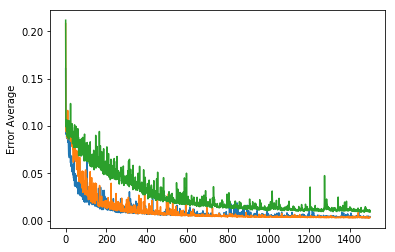

In [28]:
#show progression graph
plt.plot(total_loss_3layer,label='3 Layer CNN')
plt.plot(total_loss_5layer,label='5 Layer CNN')
plt.plot(total_loss_namish,label='Namish CNN')
plt.ylabel('Error Average')
plt.show()

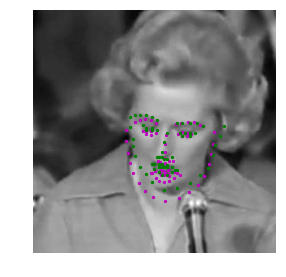

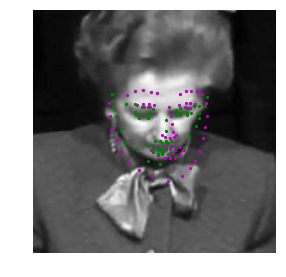

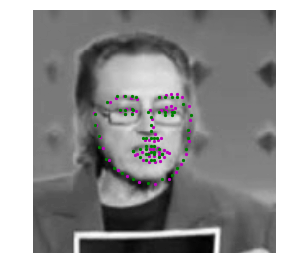

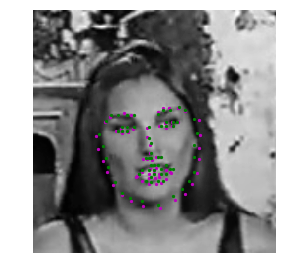

In [29]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

visualize_output(test_images, test_outputs, gt_pts,batch_size = batch_size)

In [30]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_naimishnet.pt'

# after training, save your model parameters in the dir 'saved_models'
#torch.save(net.state_dict(), model_dir+model_name)

In [ ]:
#Loads model
#net = Net()
#net.load_state_dict(torch.load(model_dir+model_name))
#net.eval()

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I used the MSE for loss mainly because it was suggested to do so. At first I tried to reuse many parts of the example on lesson "CNN Layers and Feature Visualization", but the Cross Entropy error was not suitable for this task. Mean Squared Error seemed to be a nice first attempt, and got some results like those:

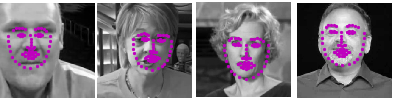

It seemed like the proportion of eyes-mouth-facial contour were correct, but scaling seemed not to be working properly. So I tried changing the loss function to L1 hoping it would have some improvement, but in fact the results got worse. Please check the images below:

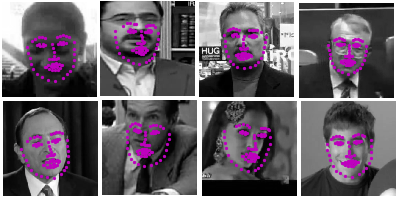

So, I switched back to MSE.

For the optimization, I started with ADAM because that is what I was using on the "CNN Layers and Feature Visualization", but after reading the article mentioned in the next question, I switched to SGD.


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: The first architecture I tried was a variation of the one used in the FashionMNIST dataset. It was composed of a convolutional layer, followed by a maxpooling layer, then another convolutional layer, followed by another maxpooling layer, and finally a linear NN to compute 136 outputs, one for each x and y coordenate os each keypoint. I tried some variations on the maxpooling stride and kernel size, but if those were too small, leading to an increase on the output, the code simply did not run on the default environment. So I saved those experiments for later, because I would have to try them on AWS with aid of GPUs.

After reading this interesting article from Florian Le Bourdais (referenced below), I decided to try 5 convolutional layers. But the time to train each epoch was too high, then I decided to make a simpler network out of this one, with 4 convolutional layers and 2 dense layers. This took a little less time to train, but the improvement over the 3 layer network was not that great.

Finally, I tried a suggestion found on the Udacity forum, called NamishNet.

It is important to notice that a huge improvement happened after I could use AWS GPUs. Usually it would take me around 20 minutes per epoch running either on Udacity platform or in my own computer. After using AWS I was able to calculate 200 epochs in around 3-4 hours. Error then dropped to around 0.005 and only then I started having satisfatory results. For this reason, the part of the instruction that states that we should try to use the notebook on Udacity environment is completely wrong.


**References**: 
http://flothesof.github.io/convnet-face-keypoint-detection.html - has an interesting implementation of facial keypoint detection. Was useful specially in using metrics to evaluate performance of the algorithm.

Agarwal, Naimish, Artus Krohn-Grimberghe, and Ranjana Vyas. "Facial Key Points Detection using Deep Convolutional Neural Network-NaimishNet." arXiv preprint arXiv:1710.00977 (2017).

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: At first, I simply kept track of loss error prints while the code was running. Then, I added a graph to keep track of error in my attempts. The idea is simply to look when an increase on the number of epoch brings an insignificant improve on the error, therefore making it a computational waste.

As said before, it was hard to perceive some improvement in the beginning because of the time each epoch took. So, for 5 epochs, error would drop just a little bit but results would still be far from acceptable.

After running on AWS, I could see that around 200-250 epochs would be enough, which can be perceived by looking at the graph curve, so I ended up using 250. Unfortunately, labels did not show up, but the green one is the namishnet, orange is the 4 layer network and the blue is the 3 layer. Each epoch has 6 measurements, so we can notice that around point 800 error seems stable and at minimum value, which mean 800 / 6 = epoch 134.

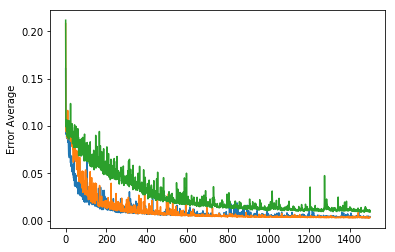

I started using batch size = 10 for performance reasons, while I was trying to run the trainning on the CPU, and forgot to change it latter. This is easy to perceive on the graph, which has a lot of noise. Later I found out that usually batch size is a multiple of 2, and optimal batch size is on the range of 32,64,128 or 256. On the next lessons I will try those values.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

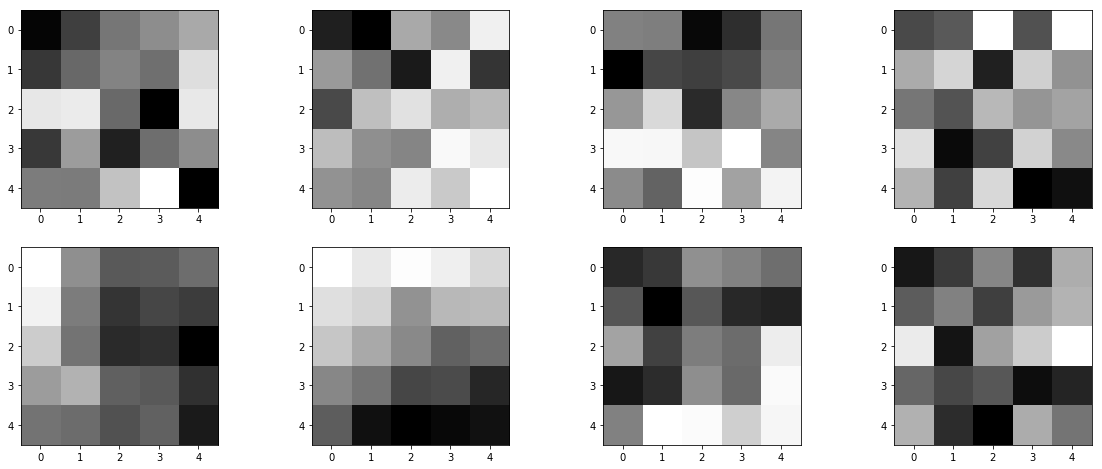

In [52]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0
fig=plt.figure(figsize=(20, 8))
columns = 4
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')



# display the filter weights
#plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

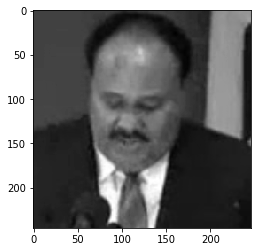

In [56]:
##TODO: load in and display any image from the transformed test dataset

images = test_images
images = images.cpu().numpy()

# select an image by index
idx = 3
img = np.squeeze(images[idx])

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w1 = weights.cpu().numpy()
weights = net.conv2.weight.data
w2 = weights.cpu().numpy()
#weights = net.conv3.weight.data
#w3 = weights.cpu().numpy()

# 1. 3 conv layer
# for 4 filters
fig=plt.figure(figsize=(246, 246))
columns = 4
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%4)==0):
        plt.imshow(w[int(i/4)][0], cmap='gray')
    elif((i%4)==1):
        c = cv2.filter2D(img, -1, w1[int((i-1)/4)][0])
        plt.imshow(c, cmap='gray')        
    elif((i%4)==2):
        c = cv2.filter2D(c, -1, w2[int((i-1)/4)][0])
        plt.imshow(c, cmap='gray') 
    #else:
        #c = cv2.filter2D(c, -1, w3[int((i-1)/4)][0])
        plt.imshow(c, cmap='gray') 




plt.show()


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: From the selection above we can see one on conv layer 1 and one on conv layer 2. One seems to be applying a smoothing filter, while another seems to detect edges.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!